In [3]:
# ! pip install pandas matplotlib seaborn scikit-learn kagglehub numpy xgboost lightgbm

In [4]:
# ! python.exe -m pip install --upgrade pip

# 1. Импорт библиотек и настройка визуализаций

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

# Настройка визуализаций

plt.style.use('ggplot')
sns.set_palette("Set2")
%matplotlib inline

d:\Documents\python_projects\Venves\diplom_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Загрузка данных

## Данные загружаются напрямую из kagglehub, что обеспечивает воспроизводимость. Загрузка датасета с помощью Kaggle API

In [6]:


path = kagglehub.dataset_download("blastchar/telco-customer-churn")
file_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

print("\nРазмер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nСтатистика числовых признаков:")
display(df.describe())


Размер датасета: (7043, 21)

Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
print("Папка с датасетом:", path)
print("CSV-файл:", file_path)


Папка с датасетом: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1
CSV-файл: C:\Users\dogot\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [8]:
# Осмотр данных: Проведен первичный анализ: проверка размера датасета, типов данных (.info()) и основных статистических показателей (.describe()).
# Это позволило выявить, что столбец TotalCharges имеет некорректный тип данных (object).

# 3. Исследовательский анализ данных (EDA)

In [9]:
# Преобразование TotalCharges в числовой формат.
# Пробелы будут заменены на NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
display(df['TotalCharges'].isnull().sum())

np.int64(11)

In [11]:
# Фильтруем строки с пропущенными TotalCharges
missing_total_charges = df[df['TotalCharges'].isnull()]

# Выводим сами строки
display(missing_total_charges)

# Сколько таких строк
print("Количество строк с пропущенными TotalCharges:", missing_total_charges.shape[0])

# Индексы этих строк
print("Индексы строк с пропусками:", missing_total_charges.index.tolist())


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Количество строк с пропущенными TotalCharges: 11
Индексы строк с пропусками: [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [12]:
# Заполняю пропущенные значения (возникшие из-за пустых строк) медианой
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [13]:
# Очистка: Проблема с TotalCharges решена путём преобразования в числовой тип и заполнения пропусков медианным значением.

## 3.1 Визуализация

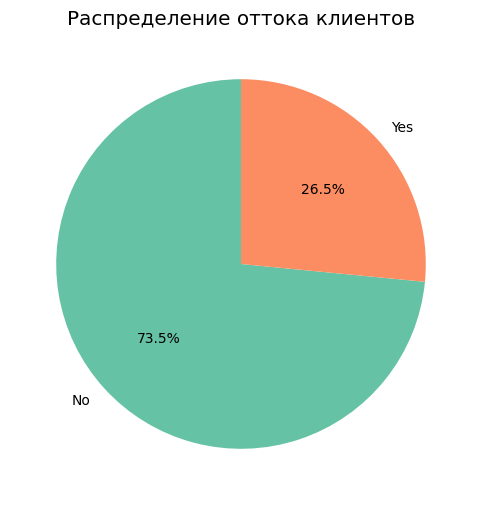

In [14]:
# Анализ целевой переменной
plt.figure(figsize=(6, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение оттока клиентов')
plt.show()

In [15]:
# Построена круговая диаграмма для оценки баланса классов целевой переменной (Churn), которая показала дисбаланс (отток составляет ~26.5%).

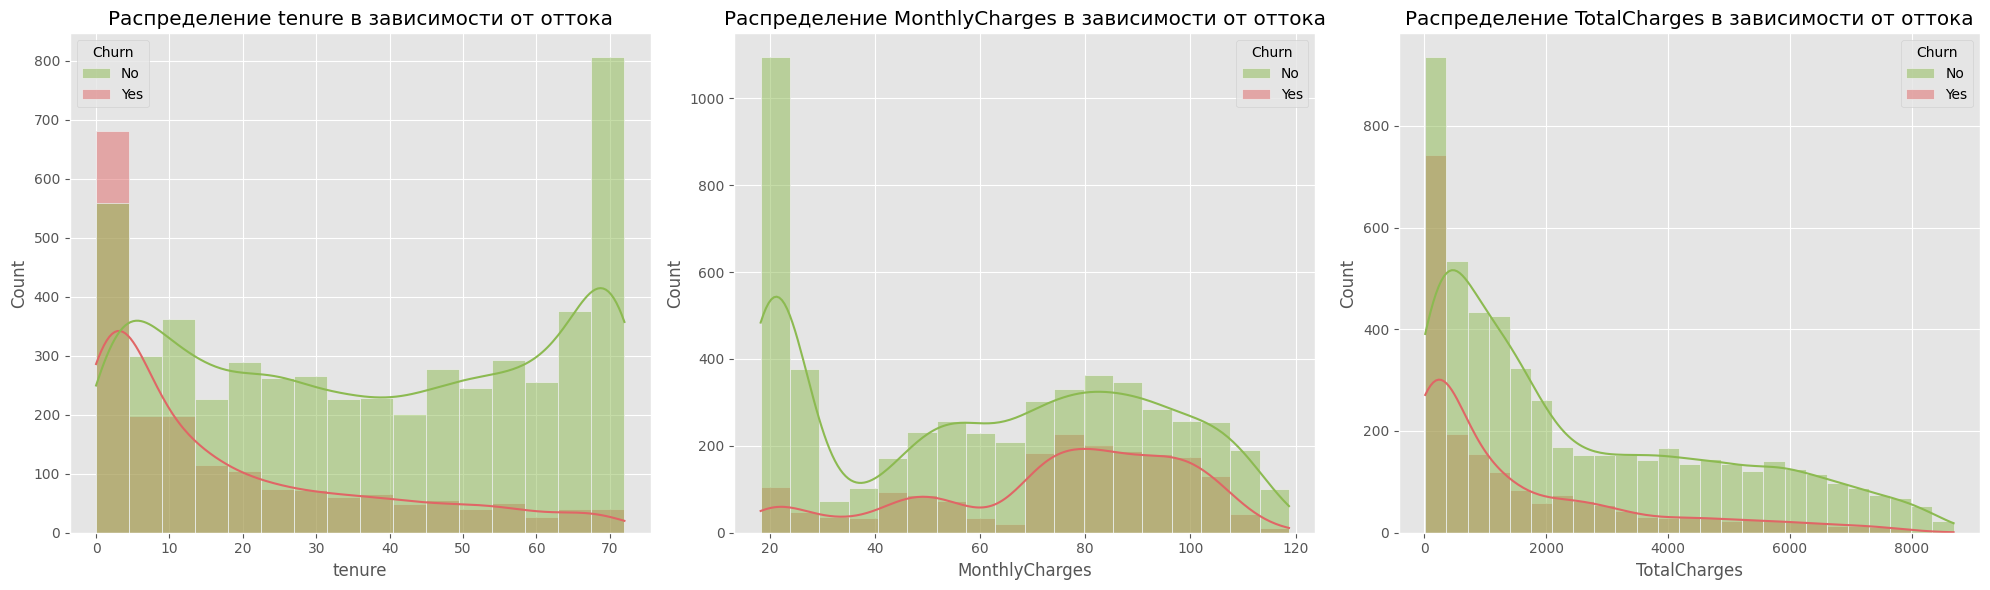

In [16]:
# Анализ числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='Churn', kde=True, ax=axes[i], palette=['#8cba51', '#e06666'])
    axes[i].set_title(f'Распределение {col} в зависимости от оттока')
plt.tight_layout()
plt.show()

In [17]:
# Гистограммы числовых признаков (tenure, MonthlyCharges, TotalCharges) в разрезе оттока наглядно показали их влияние на целевую переменную.

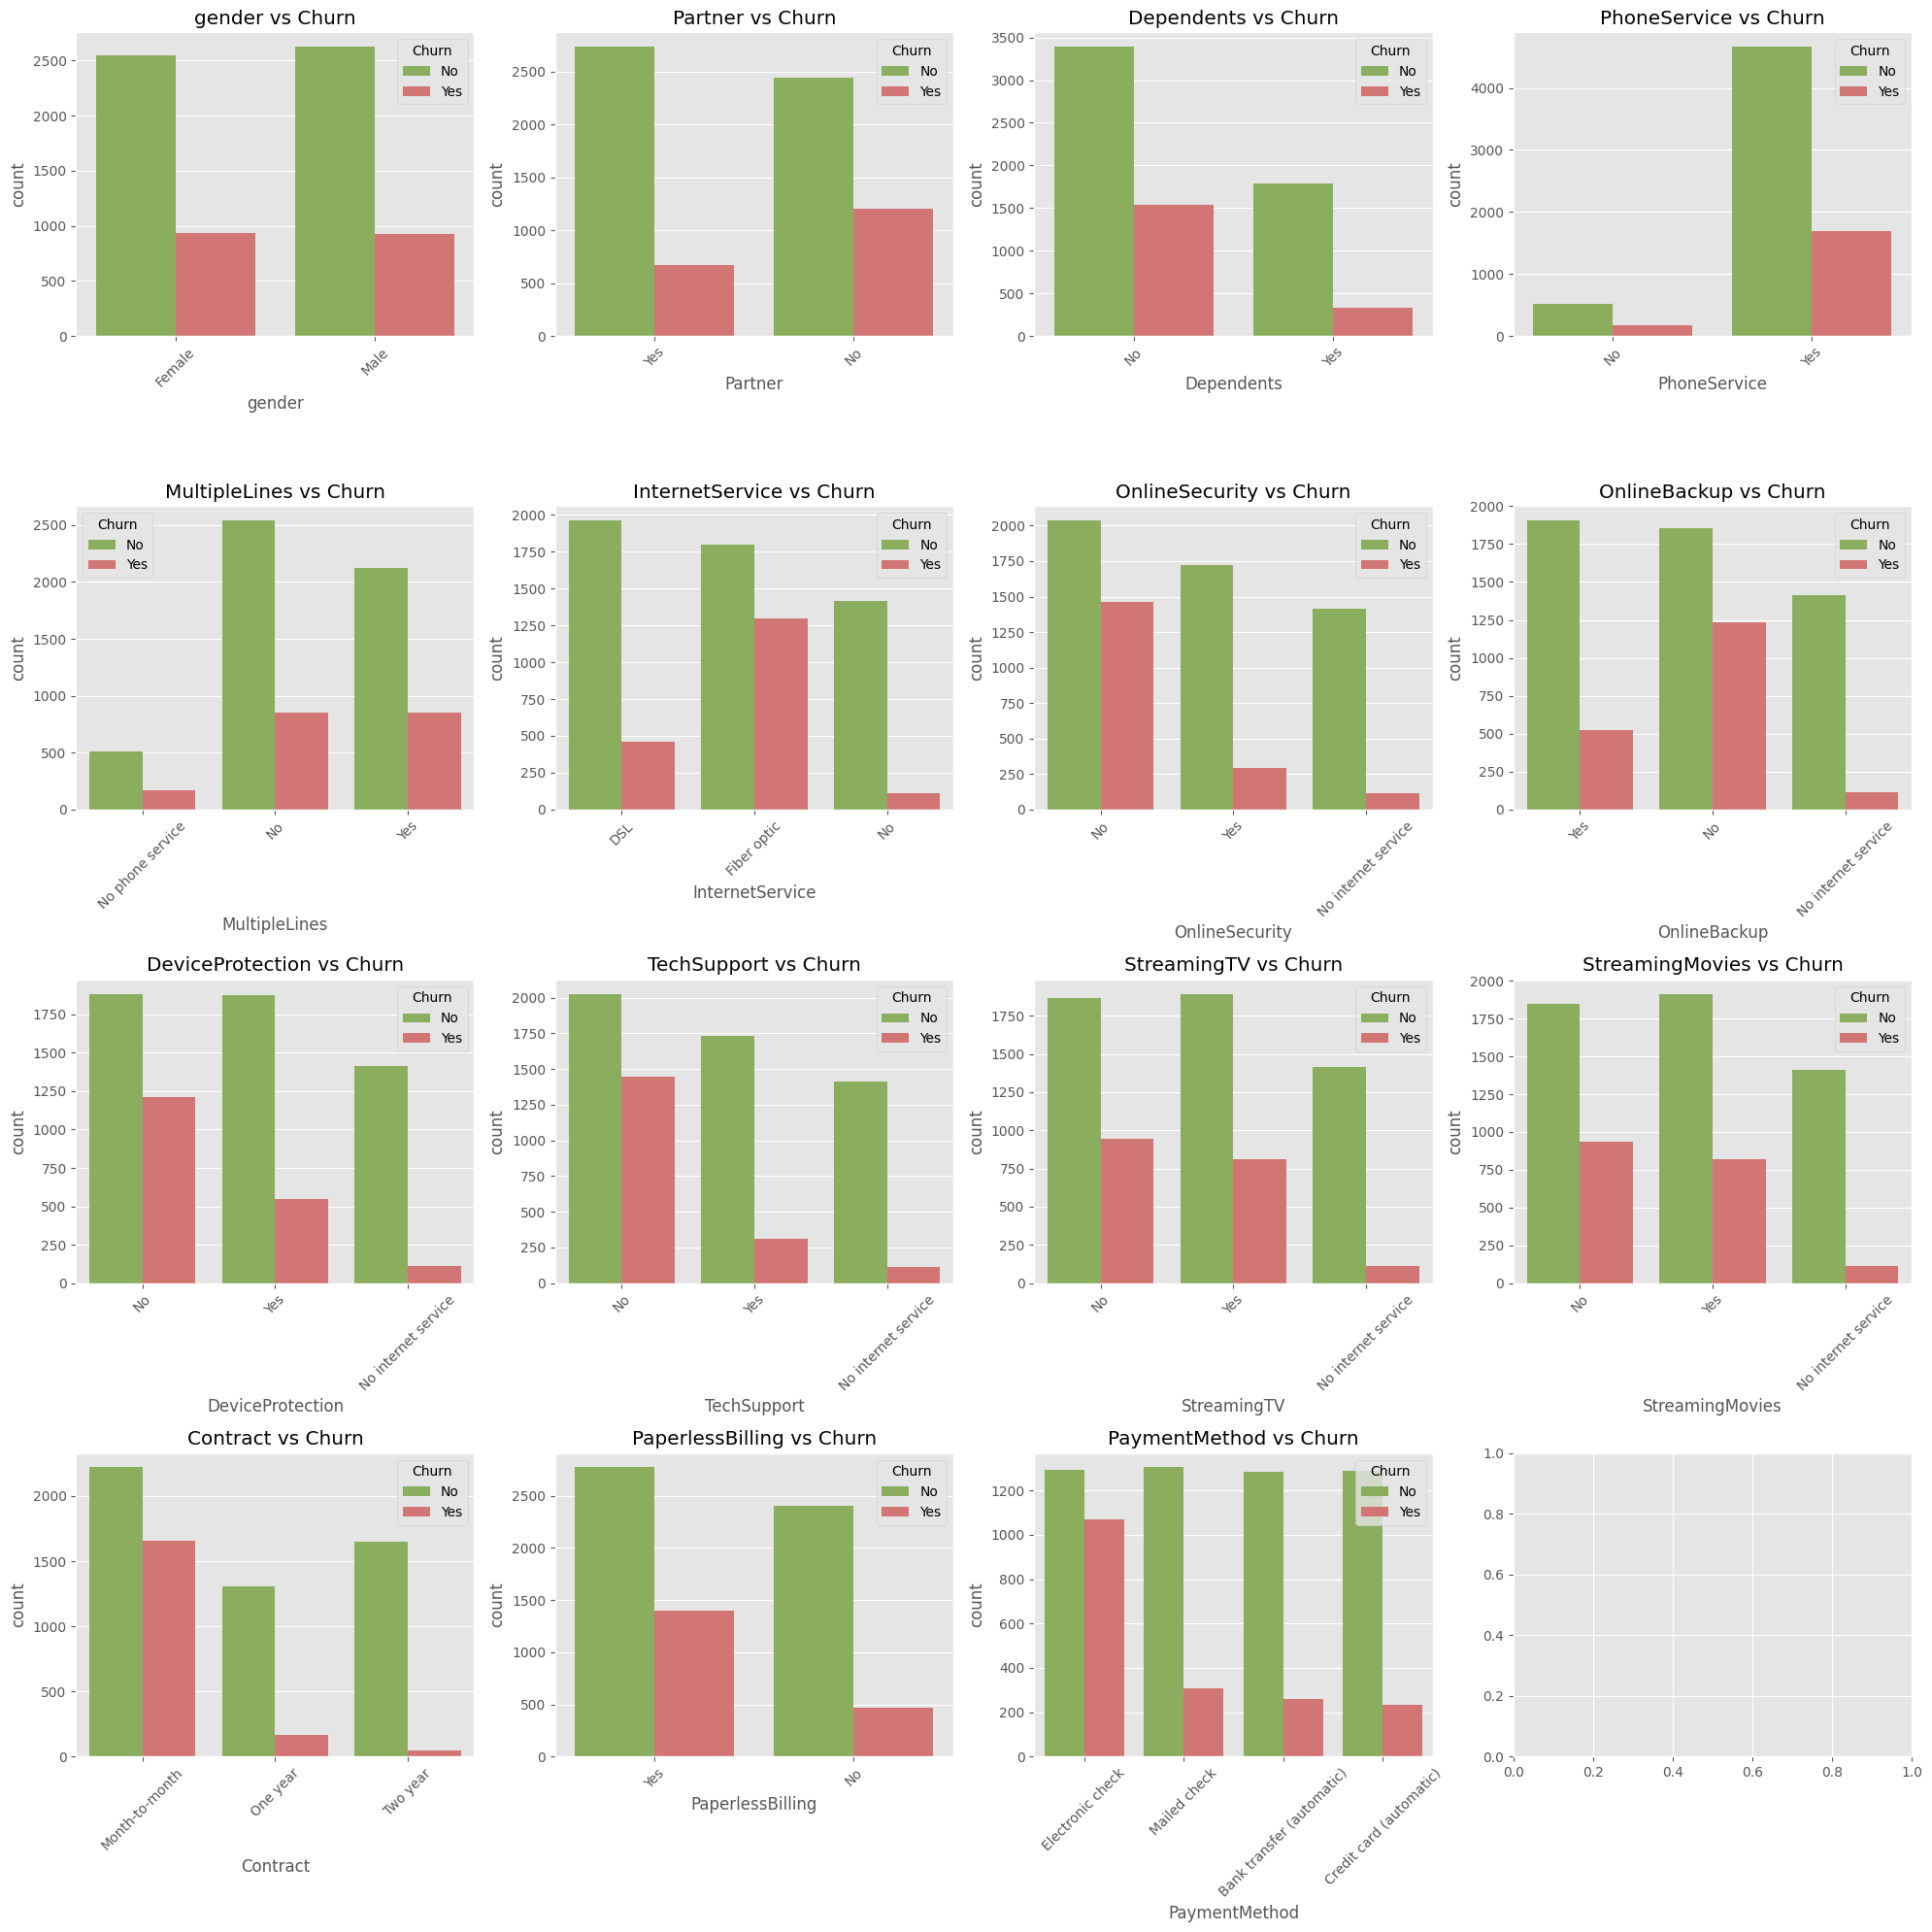

In [18]:
# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col != 'Churn':
        sns.countplot(x=col, hue='Churn', data=df, ax=axes[i], palette=['#8cba51', '#e06666'])
        axes[i].set_title(f'{col} vs Churn')
        axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Столбчатые диаграммы для категориальных признаков позволили выявить ключевые факторы, влияющие на отток (например, тип контракта, наличие техподдержки).

In [ ]:
# ! pip freeze > requirements.txt